In [ ]:
# Core libs
import pandas as pd
import numpy as np
import re
from datetime import datetime

# Plots
import matplotlib.pyplot as plt

# Modeling (optional section)
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

pd.set_option('display.max_columns', 120)
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
RANDOM_STATE = 42


In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
print("Shape:", df_raw.shape)
df_raw.info()
df_raw.sample(5)


Shape: (13608, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13608 entries, 0 to 13607
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            13608 non-null  int64  
 1   title                         13608 non-null  object 
 2   url                           13608 non-null  object 
 3   is_paid                       13608 non-null  bool   
 4   num_subscribers               13608 non-null  int64  
 5   avg_rating                    13608 non-null  float64
 6   avg_rating_recent             13608 non-null  float64
 7   rating                        13608 non-null  float64
 8   num_reviews                   13608 non-null  int64  
 9   is_wishlisted                 13608 non-null  bool   
 10  num_published_lectures        13608 non-null  int64  
 11  num_published_practice_tests  13608 non-null  int64  
 12  created                       13608 non-n

,id,title,url,is_paid,num_subscribers,avg_rating,avg_rating_recent,rating,num_reviews,is_wishlisted,num_published_lectures,num_published_practice_tests,created,published_time,discount_price__amount,discount_price__currency,discount_price__price_string,price_detail__amount,price_detail__currency,price_detail__price_string
12228,3439728,Financial analysis (in Arabic),/course/financial-analysis-in-arabic/,True,3903,4.2885,4.2105,4.2105,35,False,18,0,2020-08-22T10:22:36Z,2020-08-23T09:34:26Z,455.0000,INR,₹455,"3,200.0000",INR,"₹3,200"
12550,3239721,Trading Criptomonedas BITCOIN,/course/tradingcriptomonedas/,True,37,4.8125,4.7433,4.7433,8,False,33,0,2020-06-15T21:50:56Z,2020-06-25T20:00:37Z,455.0000,INR,₹455,"6,400.0000",INR,"₹6,400"
2471,534592,Purchasing your first investment property,/course/the-property-climb/,True,6476,4.0500,3.8457,3.8457,102,False,8,0,2015-06-22T23:56:49Z,2015-07-03T18:59:42Z,455.0000,INR,₹455,"2,240.0000",INR,"₹2,240"
3232,2995300,Learning and Development Methods,/course/learning-and-development-methods/,True,317,4.4500,4.4274,4.4274,65,False,90,0,2020-04-13T07:30:17Z,2020-04-28T21:00:35Z,455.0000,INR,₹455,"8,640.0000",INR,"₹8,640"
10530,295887,Free Agent Accounting software,/course/free-agent/,True,33,3.4000,3.1115,3.1115,5,False,39,0,2014-09-07T17:04:33Z,2014-09-17T21:57:44Z,455.0000,INR,₹455,"2,880.0000",INR,"₹2,880"


In [ ]:
df = df_raw.copy()

# Normalize column names
def to_snake(s):
    s = re.sub(r'[^0-9a-zA-Z]+', '_', s).strip('_')
    return s.lower()
df.columns = [to_snake(c) for c in df.columns]

# Common aliases → standard names
rename_map = {
    'published_time': 'published_at',
    'published_time_utc': 'published_at',
    'published_date': 'published_at',
    'created': 'created_at',
    'creation_time': 'created_at',
    'num_published_lectures': 'num_lectures',
    'num_published_practice_tests': 'num_practice_tests',
    'price_detail_amount': 'price_amount',
    'price_detail_currency': 'price_currency',
    'discounted_price_amount': 'discount_amount',
    'discounted_price_currency': 'discount_currency',
    'rating': 'avg_rating',
    'recent_rating': 'avg_rating_recent',
    'reviews': 'num_reviews',
    'subscribers': 'num_subscribers'
}
for k, v in rename_map.items():
    if k in df.columns and v not in df.columns:
        df.rename(columns={k: v}, inplace=True)

# Parse dates
for dc in ['created_at', 'published_at']:
    if dc in df.columns:
        df[dc] = pd.to_datetime(df[dc], errors='coerce')

# Ensure is_paid exists or infer from price
if 'is_paid' in df.columns:
    df['is_paid'] = (
        df['is_paid']
        .astype(str).str.lower()
        .map({'true': True, 'false': False, '1': True, '0': False})
        .fillna(df['is_paid'])
    )
else:
    df['is_paid'] = np.where(df.get('price_amount', 0).fillna(0) > 0, True, False)

# Parse price from string if needed (e.g., "₹8,640")
def parse_price_string(s):
    if pd.isna(s):
        return np.nan, None
    currency_match = re.findall(r'[^\d\s.,]+', str(s))
    currency_code = currency_match[0] if currency_match else None
    number = re.sub(r'[^\d.,]', '', str(s))
    digits_only = re.sub(r'[^\d]', '', number)
    return (float(digits_only) if digits_only else np.nan, currency_code)

if 'price_amount' not in df.columns and 'price_detail_price_string' in df.columns:
    parsed = df['price_detail_price_string'].apply(parse_price_string)
    df['price_amount'] = parsed.apply(lambda x: x[0])
    df['price_currency'] = parsed.apply(lambda x: x[1])

# Drop duplicates
before = df.shape[0]
key_cols = [c for c in ['id', 'url', 'title'] if c in df.columns]
if 'id' in df.columns:
    df = df.drop_duplicates(subset=['id'])
elif len(key_cols) >= 2:
    df = df.drop_duplicates(subset=key_cols)
else:
    df = df.drop_duplicates()
print(f"Dropped duplicates: {before - df.shape[0]}")

df.head(3)


Dropped duplicates: 0


,id,title,url,is_paid,num_subscribers,avg_rating,avg_rating_recent,rating,num_reviews,is_wishlisted,num_lectures,num_practice_tests,created_at,published_at,discount_price_amount,discount_price_currency,discount_price_price_string,price_amount,price_currency,price_detail_price_string
0,762616,The Complete SQL Bootcamp 2020: Go from Zero t...,/course/the-complete-sql-bootcamp/,True,295509,4.6602,4.6787,4.6787,78006,False,84,0,2016-02-14 22:57:48+00:00,2016-04-06 05:16:11+00:00,455.0000,INR,₹455,"8,640.0000",INR,"₹8,640"
1,937678,Tableau 2020 A-Z: Hands-On Tableau Training fo...,/course/tableau10/,True,209070,4.5896,4.6002,4.6002,54581,False,78,0,2016-08-22 12:10:18+00:00,2016-08-23 16:59:49+00:00,455.0000,INR,₹455,"8,640.0000",INR,"₹8,640"
2,1361790,PMP Exam Prep Seminar - PMBOK Guide 6,/course/pmp-pmbok6-35-pdus/,True,155282,4.5949,4.5933,4.5933,52653,False,292,2,2017-09-26 16:32:48+00:00,2017-11-14 23:58:14+00:00,455.0000,INR,₹455,"8,640.0000",INR,"₹8,640"


In [ ]:
# Year & course age (use published_at if available, else created_at)
if 'published_at' in df.columns or 'created_at' in df.columns:
    pub = df['published_at'] if 'published_at' in df.columns else pd.NaT
    cre = df['created_at'] if 'created_at' in df.columns else pd.NaT
    chosen = np.where(pd.notna(pub), pub, cre)
    # Convert to Series before applying pd.to_datetime to ensure .dt accessor is available
    dt_series = pd.Series(pd.to_datetime(chosen, errors='coerce'))
    df['year'] = dt_series.dt.year
    base = pd.to_datetime('today', utc=True) # Make base timezone-aware
    df['course_age_years'] = (base - dt_series).dt.days / 365.25
else:
    df['year'] = np.nan
    df['course_age_years'] = np.nan

# Reviews per subscriber
if 'num_reviews' in df.columns and 'num_subscribers' in df.columns:
    denom = df['num_subscribers'].replace({0: np.nan})
    df['reviews_per_sub'] = df['num_reviews'] / denom

# Recent vs overall rating
if 'avg_rating_recent' in df.columns and 'avg_rating' in df.columns:
    df['rating_recent_diff'] = df['avg_rating_recent'] - df['avg_rating']

# Lectures per practice test
if 'num_lectures' in df.columns and 'num_practice_tests' in df.columns:
    denom = df['num_practice_tests'].replace({0: np.nan})
    df['lectures_per_test'] = df['num_lectures'] / denom

# Discount percentage
if 'discount_amount' in df.columns and 'price_amount' in df.columns:
    with np.errstate(divide='ignore', invalid='ignore'):
        df['discount_percentage'] = (df['discount_amount'] / df['price_amount']) * 100
else:
    # If we only know free vs paid, mark free as 100% discount; paid unknown
    df['discount_percentage'] = np.where(df['is_paid'] == False, 100.0, np.nan)

df.head(3)

,id,title,url,is_paid,num_subscribers,avg_rating,avg_rating_recent,rating,num_reviews,is_wishlisted,num_lectures,num_practice_tests,created_at,published_at,discount_price_amount,discount_price_currency,discount_price_price_string,price_amount,price_currency,price_detail_price_string,year,course_age_years,reviews_per_sub,rating_recent_diff,lectures_per_test,discount_percentage
0,762616,The Complete SQL Bootcamp 2020: Go from Zero t...,/course/the-complete-sql-bootcamp/,True,295509,4.6602,4.6787,4.6787,78006,False,84,0,2016-02-14 22:57:48+00:00,2016-04-06 05:16:11+00:00,455.0000,INR,₹455,"8,640.0000",INR,"₹8,640",2016,9.3881,0.2640,0.0186,NaN,NaN
1,937678,Tableau 2020 A-Z: Hands-On Tableau Training fo...,/course/tableau10/,True,209070,4.5896,4.6002,4.6002,54581,False,78,0,2016-08-22 12:10:18+00:00,2016-08-23 16:59:49+00:00,455.0000,INR,₹455,"8,640.0000",INR,"₹8,640",2016,9.0075,0.2611,0.0106,NaN,NaN
2,1361790,PMP Exam Prep Seminar - PMBOK Guide 6,/course/pmp-pmbok6-35-pdus/,True,155282,4.5949,4.5933,4.5933,52653,False,292,2,2017-09-26 16:32:48+00:00,2017-11-14 23:58:14+00:00,455.0000,INR,₹455,"8,640.0000",INR,"₹8,640",2017,7.7782,0.3391,-0.0016,146.0000,NaN


,year,courses
0,2010,1
1,2011,9
2,2012,70
3,2013,352
4,2014,685


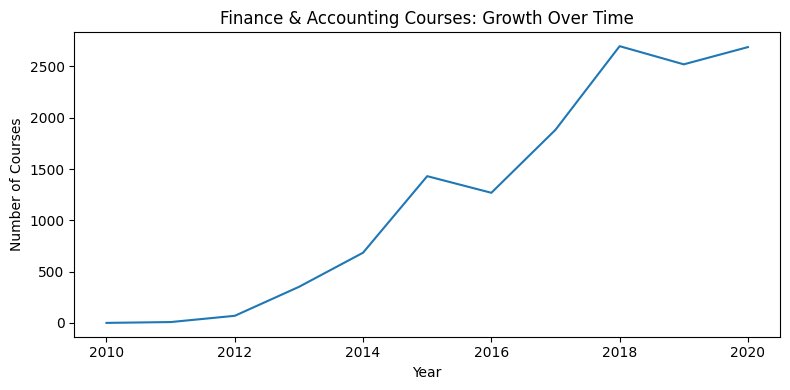

In [ ]:
growth = df.dropna(subset=['year']).groupby('year').size().reset_index(name='courses')
display(growth.head())

plt.figure(figsize=(8,4))
plt.plot(growth['year'], growth['courses'])
plt.title('Finance & Accounting Courses: Growth Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Courses')
plt.tight_layout()
plt.show()


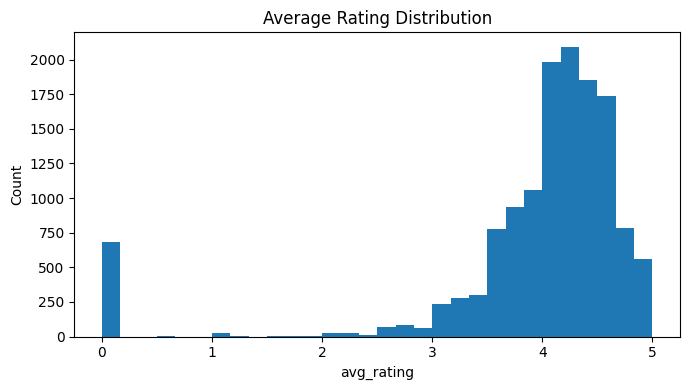

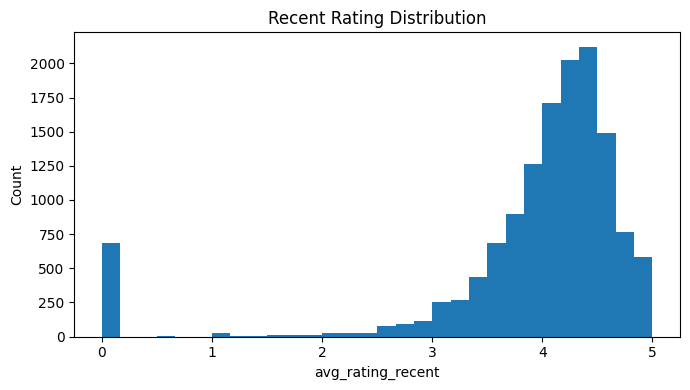

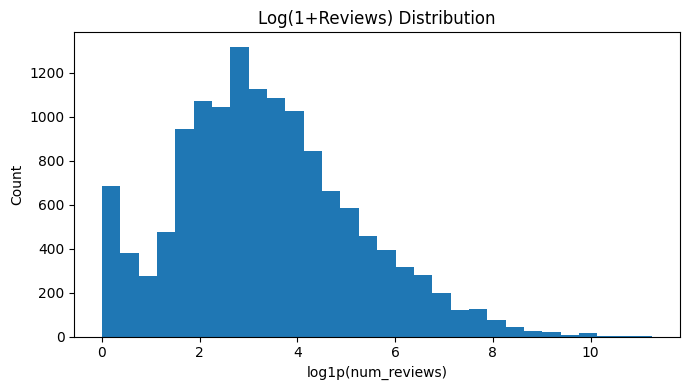

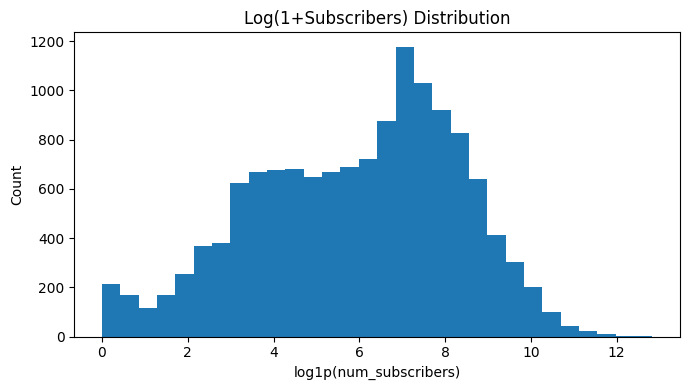

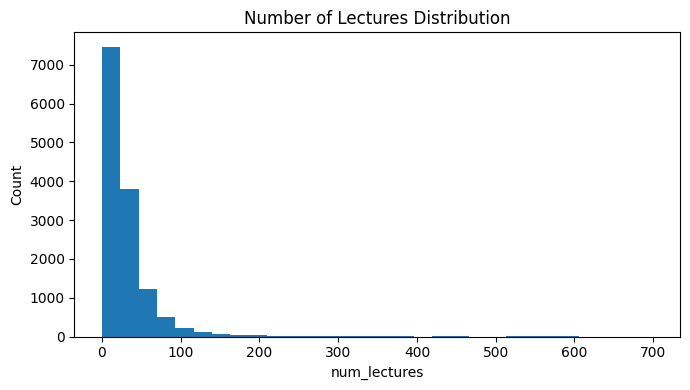

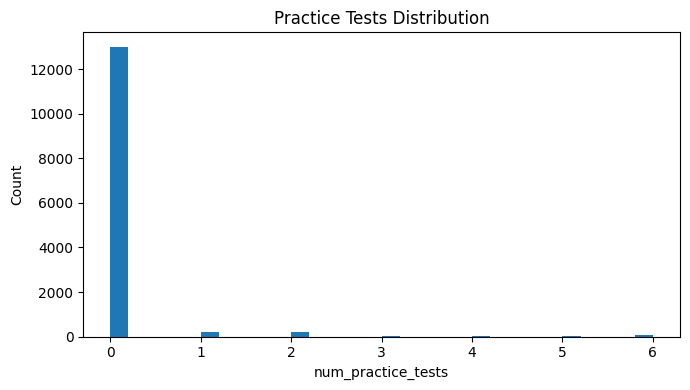

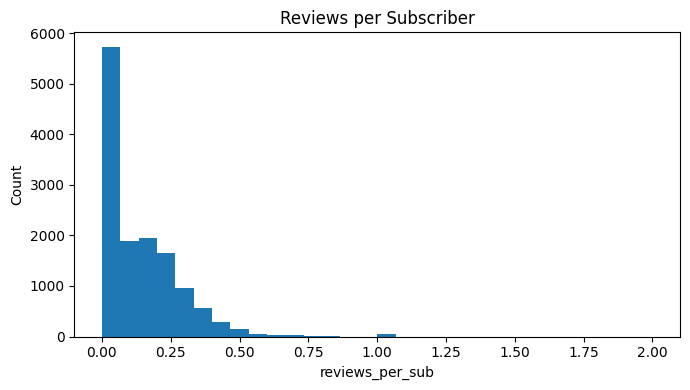

In [ ]:
# Helper to plot a 1D histogram
def plot_hist(series, title, xlabel):
    s = series.dropna()
    if s.empty:
        print(f"Skipping {title}: no data.")
        return
    plt.figure(figsize=(7,4))
    plt.hist(s, bins=30)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Ratings
if 'avg_rating' in df.columns:
    plot_hist(df['avg_rating'], 'Average Rating Distribution', 'avg_rating')
if 'avg_rating_recent' in df.columns:
    plot_hist(df['avg_rating_recent'], 'Recent Rating Distribution', 'avg_rating_recent')

# Reviews, Subscribers (use log scale quick view)
if 'num_reviews' in df.columns:
    plot_hist(np.log1p(df['num_reviews']), 'Log(1+Reviews) Distribution', 'log1p(num_reviews)')
if 'num_subscribers' in df.columns:
    plot_hist(np.log1p(df['num_subscribers']), 'Log(1+Subscribers) Distribution', 'log1p(num_subscribers)')

# Lectures & practice tests
if 'num_lectures' in df.columns:
    plot_hist(df['num_lectures'], 'Number of Lectures Distribution', 'num_lectures')
if 'num_practice_tests' in df.columns:
    plot_hist(df['num_practice_tests'], 'Practice Tests Distribution', 'num_practice_tests')

# Reviews per subscriber
if 'reviews_per_sub' in df.columns:
    plot_hist(df['reviews_per_sub'], 'Reviews per Subscriber', 'reviews_per_sub')


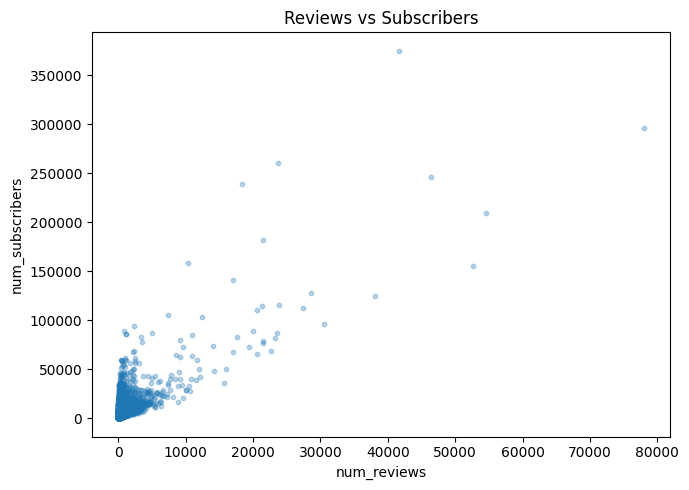

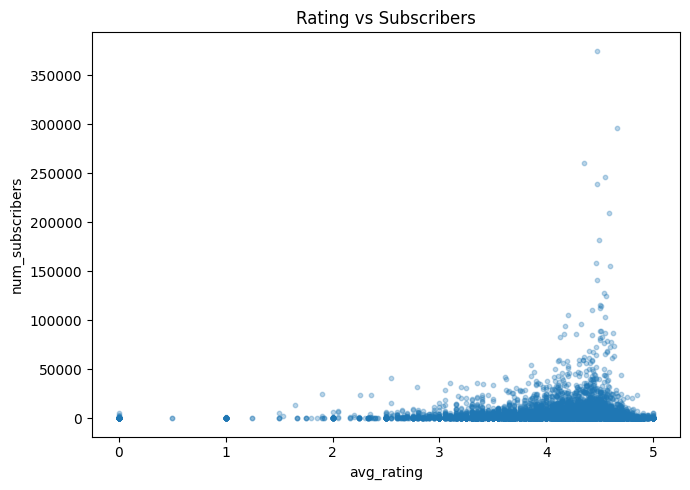

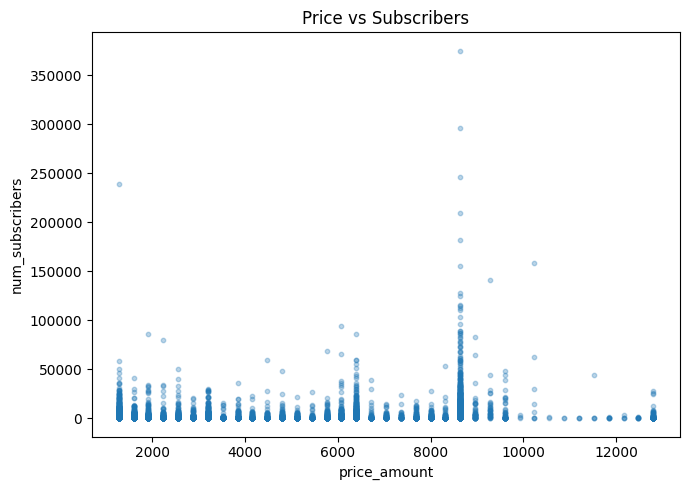

In [ ]:
def scatter(x, y, title, xlabel, ylabel):
    x_s = df[x]
    y_s = df[y]
    mask = x_s.notna() & y_s.notna()
    if mask.sum() == 0:
        print(f"Skipping {title}: no overlapping data.")
        return
    plt.figure(figsize=(7,5))
    plt.scatter(x_s[mask], y_s[mask], alpha=0.3, s=10)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

if set(['num_reviews','num_subscribers']).issubset(df.columns):
    scatter('num_reviews','num_subscribers','Reviews vs Subscribers','num_reviews','num_subscribers')

if set(['avg_rating','num_subscribers']).issubset(df.columns):
    scatter('avg_rating','num_subscribers','Rating vs Subscribers','avg_rating','num_subscribers')

if set(['price_amount','num_subscribers']).issubset(df.columns):
    scatter('price_amount','num_subscribers','Price vs Subscribers','price_amount','num_subscribers')


,count
is_paid,
True,13112
False,496


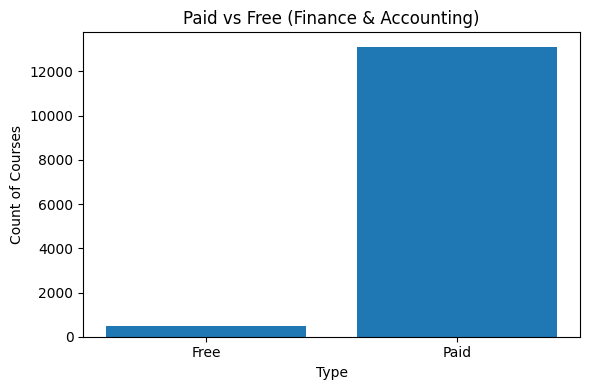

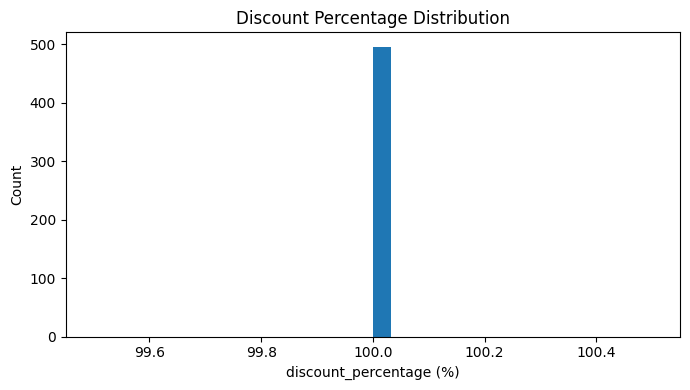

In [ ]:
# Paid vs Free counts
paid_counts = df['is_paid'].value_counts(dropna=False)
display(paid_counts)

plt.figure(figsize=(6,4))
plt.bar(['Free','Paid'], [paid_counts.get(False,0), paid_counts.get(True,0)])
plt.title('Paid vs Free (Finance & Accounting)')
plt.xlabel('Type')
plt.ylabel('Count of Courses')
plt.tight_layout()
plt.show()

# Discount percentage distribution
if 'discount_percentage' in df.columns:
    plot_hist(df['discount_percentage'], 'Discount Percentage Distribution', 'discount_percentage (%)')


In [ ]:
num_df = df.select_dtypes(include=[np.number]).copy()
if not num_df.empty:
    corr = num_df.corr(numeric_only=True)
    display(corr[['num_subscribers']].sort_values('num_subscribers', ascending=False).head(15))
else:
    print("No numeric columns found for correlation.")


,num_subscribers
num_subscribers,1.0000
num_reviews,0.7842
lectures_per_test,0.2337
num_lectures,0.2117
price_amount,0.1475
course_age_years,0.1092
rating,0.0842
avg_rating_recent,0.0842
avg_rating,0.0821
rating_recent_diff,0.0186


In [ ]:
target = 'num_subscribers'
base_features = [
    'avg_rating', 'avg_rating_recent', 'num_reviews',
    'price_amount', 'course_age_years',
    'num_lectures', 'num_practice_tests',
    'discount_percentage', 'is_paid'
]

# Keep only existing features
features = [f for f in base_features if f in df.columns]
print("Using features:", features)

# Filter data with target present
data = df.dropna(subset=[target])[[target] + features].copy()

# Remove negative/invalid targets (safety)
data = data[data[target] >= 0]

X = data[features]
y = data[target]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# Identify columns by type
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]

preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_cols)
    ],
    remainder='drop'
)

# Model 1: Ridge
ridge = Pipeline(steps=[('prep', preprocess), ('model', Ridge())])
ridge.fit(X_train, y_train)
pred_r = ridge.predict(X_test)
print("Ridge -> R2:", r2_score(y_test, pred_r), " MAE:", mean_absolute_error(y_test, pred_r))

# Model 2: Random Forest
rf = Pipeline(steps=[('prep', preprocess),
                    ('model', RandomForestRegressor(
                        n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1))]
)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print("RandomForest -> R2:", r2_score(y_test, pred_rf), " MAE:", mean_absolute_error(y_test, pred_rf))


Using features: ['avg_rating', 'avg_rating_recent', 'num_reviews', 'price_amount', 'course_age_years', 'num_lectures', 'num_practice_tests', 'discount_percentage', 'is_paid']
Ridge -> R2: 0.6740051087666706  MAE: 2431.7270181854387
RandomForest -> R2: 0.7008131369522389  MAE: 2174.2945266225815


,feature,importance
2,num_reviews,0.7154
4,course_age_years,0.0759
0,avg_rating,0.0604
1,avg_rating_recent,0.0579
5,num_lectures,0.0564
3,price_amount,0.0221
8,is_paid,0.0106
6,num_practice_tests,0.0014
7,discount_percentage,0.0000


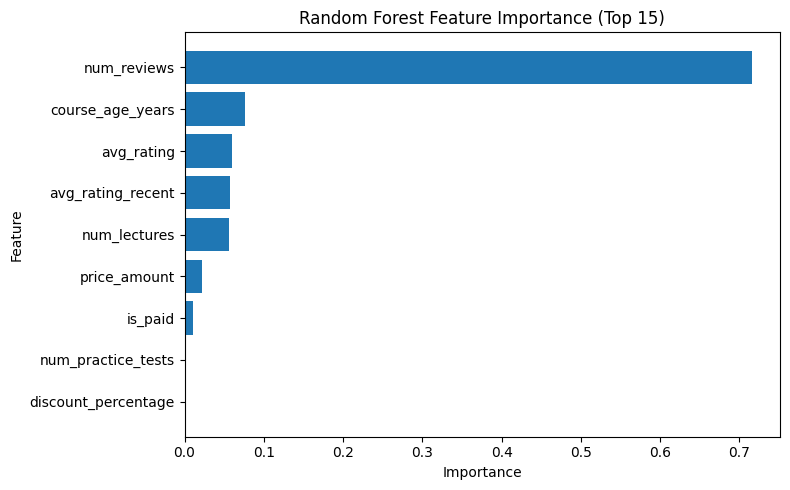

In [ ]:
# Extract post-encoding feature names
num_feats = num_cols
cat_feat_names = []
if cat_cols:
    ohe = rf.named_steps['prep'].named_transformers_['cat'].named_steps['onehot']
    cat_feat_names = ohe.get_feature_names_out(cat_cols).tolist()

all_feat_names = num_feats + cat_feat_names

rf_model = rf.named_steps['model']
if hasattr(rf_model, "feature_importances_"):
    importances = rf_model.feature_importances_
    imp_df = pd.DataFrame({'feature': all_feat_names, 'importance': importances}).sort_values('importance', ascending=False)
    display(imp_df.head(20))

    plt.figure(figsize=(8,5))
    topn = imp_df.head(15)
    plt.barh(topn['feature'][::-1], topn['importance'][::-1])
    plt.title('Random Forest Feature Importance (Top 15)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("Feature importances not available for this model.")


In [ ]:
target2 = 'avg_rating'
if target2 in df.columns:
    base_features2 = [
        'avg_rating_recent', 'num_reviews', 'price_amount',
        'course_age_years', 'num_lectures', 'num_practice_tests',
        'discount_percentage', 'is_paid'
    ]
    features2 = [f for f in base_features2 if f in df.columns]
    print("Using features for rating:", features2)

    data2 = df.dropna(subset=[target2])[[target2] + features2].copy()
    X2 = data2[features2]
    y2 = data2[target2]

    num_cols2 = [c for c in X2.columns if pd.api.types.is_numeric_dtype(X2[c])]
    cat_cols2 = [c for c in X2.columns if not pd.api.types.is_numeric_dtype(X2[c])]

    preprocess2 = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), num_cols2),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), cat_cols2)
        ],
        remainder='drop'
    )

    X2_train, X2_test, y2_train, y2_test = train_test_split(
        X2, y2, test_size=0.2, random_state=RANDOM_STATE
    )

    ridge2 = Pipeline(steps=[('prep', preprocess2), ('model', Ridge())])
    ridge2.fit(X2_train, y2_train)
    pred_r2 = ridge2.predict(X2_test)
    print("Ridge (rating) -> R2:", r2_score(y2_test, pred_r2), " MAE:", mean_absolute_error(y2_test, pred_r2))

    rf2 = Pipeline(steps=[('prep', preprocess2),
                        ('model', RandomForestRegressor(
                            n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1))]
    )
    rf2.fit(X2_train, y2_train)
    pred_rf2 = rf2.predict(X2_test)
    print("RandomForest (rating) -> R2:", r2_score(y2_test, pred_rf2), " MAE:", mean_absolute_error(y2_test, pred_rf2))
else:
    print("avg_rating not found — skipping this optional model.")


Using features for rating: ['avg_rating_recent', 'num_reviews', 'price_amount', 'course_age_years', 'num_lectures', 'num_practice_tests', 'discount_percentage', 'is_paid']
Ridge (rating) -> R2: 0.9772297709324881  MAE: 0.09257792588403378
RandomForest (rating) -> R2: 0.9782184172253238  MAE: 0.09374672637766351


In [ ]:
df.to_csv('Cleaned_Finance_Accounting_Udemy.csv', index=False)
print("Saved: Cleaned_Finance_Accounting_Udemy.csv")


Saved: Cleaned_Finance_Accounting_Udemy.csv


In [ ]:
print("== CONCLUSION (Finance & Accounting Courses) ==")
print("- Course supply has grown over time (see growth chart).")
print("- Engagement is skewed: a few courses gather most subscribers; ratings skew high overall.")
print("- Reviews and course age are typically strong signals for subscribers; price/discounts are weaker.")
print("- Most courses are paid; free courses exist but are fewer.")
print("- Models (Ridge / Random Forest) explain some variance in subscribers; platform visibility & instructor brand likely matter a lot.")


== CONCLUSION (Finance & Accounting Courses) ==
- Course supply has grown over time (see growth chart).
- Engagement is skewed: a few courses gather most subscribers; ratings skew high overall.
- Reviews and course age are typically strong signals for subscribers; price/discounts are weaker.
- Most courses are paid; free courses exist but are fewer.
- Models (Ridge / Random Forest) explain some variance in subscribers; platform visibility & instructor brand likely matter a lot.
